Dosya: car10.jpg | Skor: 143 | Algılanan: BULANIK (Agresif Mod)


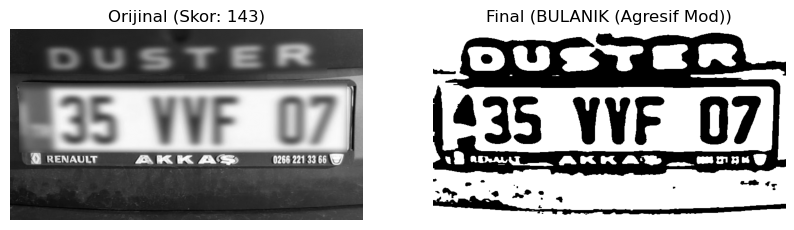

Dosya: car5.jpg | Skor: 383 | Algılanan: NET (Gaussian Optimize)


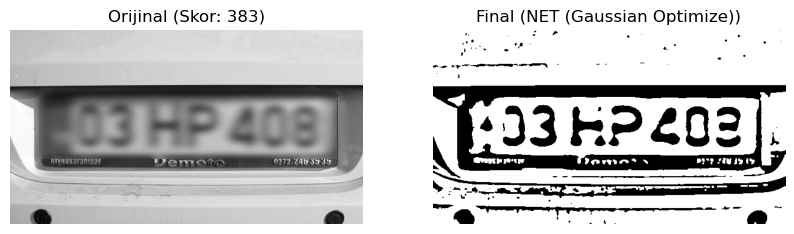

Dosya: car6.jpg | Skor: 42 | Algılanan: BULANIK (Agresif Mod)


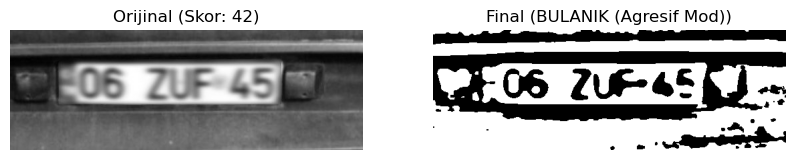

Dosya: car7.jpg | Skor: 253 | Algılanan: NET (Gaussian Optimize)


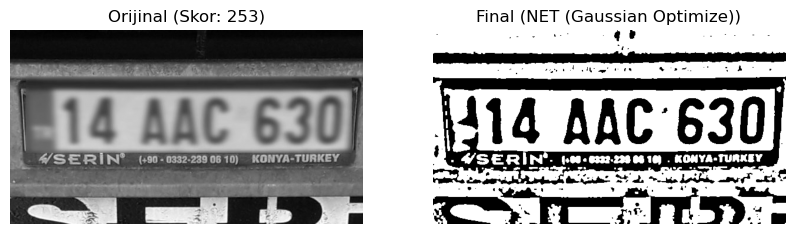

Dosya: car8.jpg | Skor: 119 | Algılanan: BULANIK (Agresif Mod)


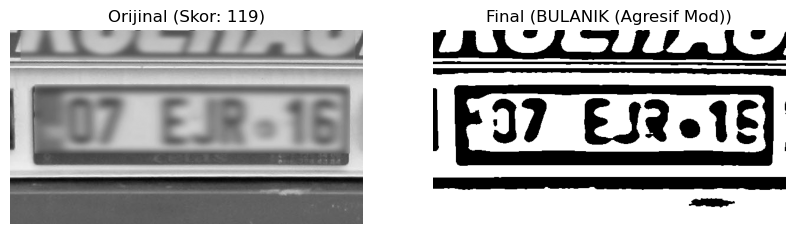

Dosya: WhatsApp Image 2025-12-19 at 5.30.26 PM.jpeg | Skor: 31 | Algılanan: BULANIK (Agresif Mod)


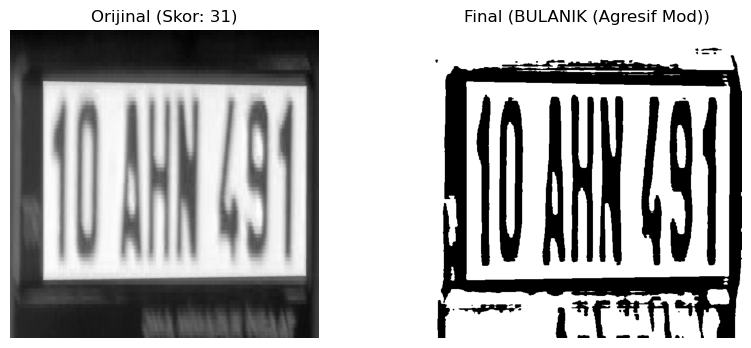

Dosya: WhatsApp Image 2025-12-19 at 5.30.27 PM.jpeg | Skor: 82 | Algılanan: BULANIK (Agresif Mod)


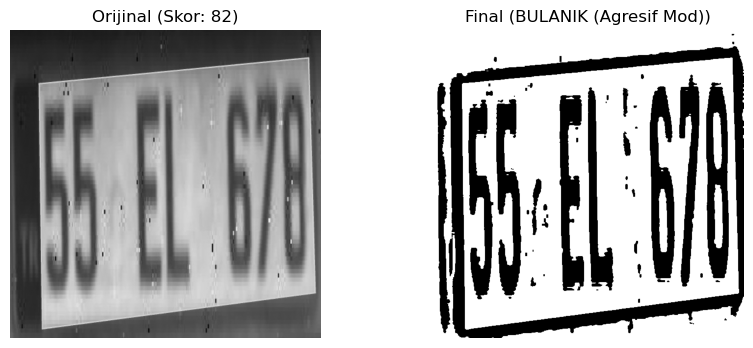

Dosya: WhatsApp Image 2025-12-19 at 5.30.27 PMd.jpeg | Skor: 249 | Algılanan: NET (Gaussian Optimize)


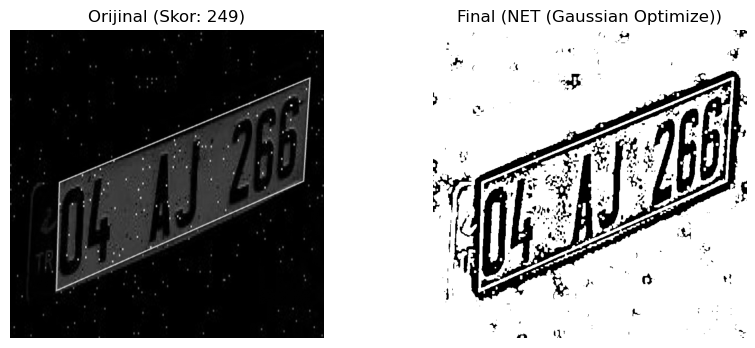

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

images_folder = 'images'
output_folder = 'outputs/final_polished'
os.makedirs(output_folder, exist_ok=True)

plt.rcParams['figure.figsize'] = (14, 8)

def get_blur_score(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# YÖNTEM 1: NET RESİMLER İÇİN 
def process_sharp_image_optimized(gray):
    # 1) Görseli normalize et (0-255 aralığına getir)
    # Bu, parlaklık farklarını azaltır ve threshold için daha dengeli bir giriş sağlar
    norm_img = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  
    # 2) Hafif Gaussian Blur uygula
    blurred = cv2.GaussianBlur(norm_img, (5, 5), 0)
    
    # 3) Adaptive Threshold (GAUSSIAN) uygula
    # Her bölgeye lokal eşik değeri hesaplanır, harfler bütün çıkar
    thresh = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Lokal eşik için Gaussian yöntemi
        cv2.THRESH_BINARY_INV,            # Beyaz zemin, siyah harf
        45,                               # Block size: eşik için kullanılan lokal pencere
        4                                 # C: eşik değerinden çıkarılacak sabit (düşük değer → harf içi boşluklar da siyah olur)
    )
    
    # 4) Morfolojik Close ile küçük boşlukları kapat
    # Harf içindeki minik kopukluklar birleştirilir
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    return cleaned

# YÖNTEM 2: BULANIK RESİMLER İÇİN (AGRESİF MOD)
def process_blurry_image_aggressive(gray):
    # 1) Normalize et (0-255 aralığı)
    norm_img = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # 2️) Median Blur ile gürültüyü azalt
    # Bulanık resimlerde, kenar ve harfleri daha belirgin hale getirir
    blurred = cv2.medianBlur(norm_img, 5)
    
    # 3️) Adaptive Threshold (MEAN) uygula
    # Her bölgeye lokal ortalama hesaplanır, harfleri çıkarmak için agresif eşikleme
    thresh = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,     # Ortalama yöntemi
        cv2.THRESH_BINARY_INV,           # Beyaz zemin, siyah harf
        51,                              # Block size: lokal pencere
        8                                # C: eşikten çıkarılacak sabit (yüksek değer → daha agresif threshold)
    )
    
    # 4️) Morfolojik Close (yatay) ile harfleri birleştir
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    connected = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_horizontal)

    # 5️) Dilation ile harfleri kalınlaştır
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thickened = cv2.dilate(connected, kernel_dilate, iterations=1)
    
    return thickened

# ANA DÖNGÜ
files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

if not files:
    print("Resim bulunamadı!")
else:
    for img_file in files:
        img_path = os.path.join(images_folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue

        # Griye Çevir
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # SKORU ÖLÇ
        blur_score = get_blur_score(gray)
        THRESHOLD_SCORE = 200 

        if blur_score > THRESHOLD_SCORE:
            status = "NET (Gaussian Optimize)"
            # YENİ Optimize Edilmiş Fonksiyon
            final = process_sharp_image_optimized(gray)
        else:
            status = "BULANIK (Agresif Mod)"
            final = process_blurry_image_aggressive(gray)

        # Sonucu Kaydetme Kısmı
        final_save = cv2.bitwise_not(final)
        cv2.imwrite(f'{output_folder}/{img_file}', final_save)
        
        print(f"Dosya: {img_file} | Skor: {int(blur_score)} | Algılanan: {status}")

        # GÖRSELLEŞTİRME
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title(f"Orijinal (Skor: {int(blur_score)})")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(final_save, cmap='gray')
        plt.title(f"Final ({status})")
        plt.axis('off')
        plt.show()